# Time Series Forecasting using Deep Learning - Milestone 3

This Jupyter notebook serves as a solution to Milestone 3 of the liveProject on Time Series Forecasting using Deep Learning.
The liveProject is the second part of a series titled "End-to-end Time Series Forecasting with Deep Learning".

Having explored two deep learning algorithms (LSTM and N-BEATS), our aim in this Milestone is to find out how to tune the hyperparameters of the models. We shall make fuller use of the TensorBoard to compare the performances of various models. At the same time, we shall leverage on a popular package called [Optuna](https://optuna.org/) to search the hyperparameter space for an optimal set of hyperparameters.

![Milestone 3](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/project2_milestone3.PNG)

## Importing Necessary Libraries and Functions

Let us first import the necessary libraries that we will be using throughout this Milestone. 

In this liveProject, you are a data scientist at a large retailer and your challenge is to forecast the sales of the respective stores by each category for the next 28 days.

<ins>Instructions</ins>:<br>
- We have written the code to import the libraries so you can just run it. If you need other libraries while working on this notebook, please feel free to add the library to this cell below.

In [5]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
  !pip install torchmetrics==0.5.0
  !pip install pytorch-forecasting  # Do restart runtime when prompted if you are running this in Colab

# import necessary libraries
import pandas as pd
import numpy as np
import optuna
import joblib
import time

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, NBeats
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, MAPE, MASE

# load TensorBoard notebook extension
%load_ext tensorboard

# allow Matplotlib plots display within notebook 
%matplotlib inline

# suppress pandas SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Prerequisite Resources

Similar to previous Milestones, let's also load our prerequisite resources.

<ins>Prerequisite resources</ins>:
1. Cleaned data
2. Cross validation function 
3. Model metrics calculation functions

<ins>Instructions</ins>:<br>
- Execute the code in the *Prerequisite Resources* section

### Cleaned data

In [3]:
# read in our sales_cleaned.csv data
if RunningInCOLAB:
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [4]:
# read in our processed data
# by using parse_dates in parameter of read_csv, we can convert date column to datetime format without additional step
if RunningInCOLAB:
  sales_df = pd.read_csv('./sales_cleaned.csv', parse_dates=['date'])
else:
  sales_df = pd.read_csv('../data/sales_cleaned.csv', parse_dates=['date'])  # use this if running notebook in local 

sales_df['time_idx'] = (sales_df['date'] - sales_df['date'].min()).dt.days

sales_df.info()
sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54384 entries, 0 to 54383
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   store_id   54384 non-null  object        
 1   cat_id     54384 non-null  object        
 2   date       54384 non-null  datetime64[ns]
 3   sales      54384 non-null  float64       
 4   series_id  54384 non-null  object        
 5   time_idx   54384 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 2.5+ MB


,store_id,cat_id,date,sales,series_id,time_idx
0,TX_1,FOODS,2011-01-29,3950.35,TX_1_FOODS,0
1,TX_1,FOODS,2011-01-30,3844.97,TX_1_FOODS,1
2,TX_1,FOODS,2011-01-31,2888.03,TX_1_FOODS,2
3,TX_1,FOODS,2011-02-01,3631.28,TX_1_FOODS,3
4,TX_1,FOODS,2011-02-02,3072.18,TX_1_FOODS,4


### Cross validation function

In [5]:
def get_cv_split(df, split_num, prediction_length=28, validation=True):
    """
    Implement train-test split given a cv split number and return training, val and test data
    """
    if 'series_id' not in df.columns:
        df['series_id'] = df['store_id'] + '_' + df['cat_id']
    series_list = df['series_id'].unique()

    test_list = []
    validation_list = []
    training_list = []

    for series in series_list:
        df_series = df.loc[df.series_id==series]
        max_date = df_series.date.max()
        min_date = df_series.date.min()
        test_lower_date = max_date - pd.Timedelta(f"{prediction_length*((split_num+1)*2-1)} days")
        test_upper_date = max_date - pd.Timedelta(f"{prediction_length*(split_num*2)} days")
        val_lower_date = max_date - pd.Timedelta(f"{prediction_length*(split_num+1)*2} days")
        if min(test_lower_date, test_upper_date) < min_date:
            raise Exception("Insufficient data for splitting")

        df_series_test = df_series.loc[(df_series.date > test_lower_date) & (df_series.date <= test_upper_date)]
        if validation:
            df_series_val = df_series.loc[(df_series.date > val_lower_date) & (df_series.date <= test_lower_date)]
            df_series_train = df_series.loc[df_series.date <= val_lower_date]
        else:
            df_series_val = pd.DataFrame()
            df_series_train = df_series.loc[df_series.date <= test_lower_date]
        test_list.append(df_series_test)
        validation_list.append(df_series_val)
        training_list.append(df_series_train)

    test_df = pd.concat(test_list)
    validation_df = pd.concat(validation_list)
    training_df = pd.concat(training_list)
    return training_df, validation_df, test_df

### Model metrics calculation functions

In [6]:
def compute_mae(training_df, prediction_test_df, y, y_hat, series_id):
    """
    Given a time series ID, compute the MAE for that time series and return the last 28-day training sales
    """
    prediction_test_df_series = prediction_test_df.loc[prediction_test_df.series_id==series_id]
    training_df_series = training_df.loc[training_df.series_id==series_id]
    training_df_series.sort_values(by='date', ascending=False, inplace=True)
    prediction_test_df_series['abs_error'] = (prediction_test_df_series[y_hat] - prediction_test_df_series[y]).abs()
    mae = prediction_test_df_series['abs_error'].mean()
    total_sales = training_df_series[:28]['sales'].sum()
    return mae, total_sales

def compute_wmae(training_df, prediction_test_df, y, y_hat):
    """
    Given a training and prediction data, compute the weighted MAE
    """
    series_list = prediction_test_df.series_id.unique()
    sales_list = []
    mae_list = []
    for series in series_list:
        mae_series, total_sales_series = compute_mae(training_df, prediction_test_df, y, y_hat, series)
        mae_list.append(mae_series)
        sales_list.append(total_sales_series)
    overall_sales = np.sum(sales_list)
    weights_list = [s/overall_sales for s in sales_list]
    wmae_list = [a*b for a,b in zip(mae_list, weights_list)]
    wmae = np.sum(wmae_list)
    return wmae

In [7]:
def compute_mape(training_df, prediction_test_df, y, y_hat, series_id):
    """
    Given a time series ID, compute the MAPE for that time series and return the last 28-day training sales
    """
    training_df_series = training_df.loc[training_df.series_id==series_id]
    training_df_series.sort_values(by='date', ascending=False, inplace=True)
    prediction_test_df_series = prediction_test_df.loc[prediction_test_df.series_id==series_id]
    prediction_test_df_series['abs_pct_error'] = ((prediction_test_df_series[y] - prediction_test_df_series[y_hat])/prediction_test_df_series[y]).abs()
    mape = prediction_test_df_series['abs_pct_error'].mean()
    total_sales = training_df_series[:28]['sales'].sum()
    return mape, total_sales

def compute_wmape(training_df, prediction_test_df, y, y_hat):
    """
    Given a training and prediction data, compute the weighted MAPE
    """
    series_list = prediction_test_df.series_id.unique()
    sales_list = []
    mape_list = []
    for series in series_list:
        mape_series, total_sales_series = compute_mape(training_df, prediction_test_df, y, y_hat, series)
        mape_list.append(mape_series)
        sales_list.append(total_sales_series)
    overall_sales = np.sum(sales_list)
    weights_list = [s/overall_sales for s in sales_list]
    wmape_list = [a*b for a,b in zip(mape_list, weights_list)]
    wmape = np.sum(wmape_list)
    return wmape

### TensorBoard HParams Dashboard

While you were looking at the TensorBoard in the previous Milestones, you may have noticed a tab called "HPARAMS" (see screenshot below). This is actually a [feature](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams) that allows one to visualize and compare the model performances of various sets of hyperparameters.

![Screenshot of HParams dashboard](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/hparams_table.PNG)

It is a useful feature but we did not use it previously because our HParams dashboard was not setup correctly. On closer look, you will realise that the *hp_metric* is always equal to -1 for all runs (we will use the term "run" interchangeably with "experiment" or "trial"). The *hp_metric* should ideally show our validation loss so that we can compare the model performances across different sets of hyperparameters. Hence, let's try to correct this "error".  

<ins>Root cause</ins>:<br>
Examining the [source code of *TensorBoardLogger*](https://pytorch-lightning.readthedocs.io/en/stable/_modules/pytorch_lightning/loggers/tensorboard.html#TensorBoardLogger), we managed to locate the lines of code causing *hp_metric* to be -1:

```
if metrics is None:
    if self._default_hp_metric:
        metrics = {"hp_metric": -1}
```

The following [documentation](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html?highlight=hp_metric#logging-hyperparameters) from PyTorch Lightning then provides some guidance on how to write our own metric to *hp_metric*.

> """

> If you want to track a metric in the tensorboard hparams tab, log scalars to the key `hp_metric`.

> """

Unfortunately, we are using *PyTorch Forecasting* on top of *PyTorch Lightning*, so it is not so straightforward for us to modify the code directly. 

The good news is that we can still write our validation loss to *hp_metric* through a callback. Previously, we have implemented the ModelCheckpoint callback to monitor the validation loss and save the best checkpoint. Now, we shall implement a callback that will be invoked at the end of each validation step to write the best validation loss to *hp_metric*.

For our context, we shall test our callback with the N-BEATS model. 

With reference to PyTorch Lightning's [documentation on callbacks](https://pytorch-lightning.readthedocs.io/en/latest/extensions/callbacks.html#), we wrote a class called *ModifyHPMetric* to literally modify the *hp_metric* with the validation loss.

In [8]:
class ModifyHPMetric(Callback):
    """
    PyTorch Lightning callback to write value of val_loss to hp_metric
    """
    def __init__(self):
        super().__init__()
        self.best_metric = None

    def on_validation_end(self, trainer, pl_module):
        """
        At end of each validation, log the best validation loss to hp_metric
        """         
        metrics = trainer.callback_metrics
        val_loss = metrics["val_loss"]
        if self.best_metric is None:
            self.best_metric = val_loss
        else:
            if val_loss < self.best_metric:  # only log smallest val_loss
                self.best_metric = val_loss
        trainer.logger.log_metrics({"hp_metric": self.best_metric})

We then add the callback to our *nbeats_modeler* function.

<ins>Instructions</ins>:<br>
- Using the N-BEATS basic model as context, modify the code to correct the error.

In [9]:
def nbeats_modeler(training_df, validation_df, test_df, 
                 max_prediction_length=28, max_encoder_length=28*5,
                 num_blocks=[1,1], num_block_layers=[3,3],
                 expansion_coefficient_lengths=[3,3], 
                 batch_size=256, max_epochs=5, loss=MASE()):    
    """
    Return the N-BEATS model, trainer and dataloaders given the training, validation 
    and test dataframes, and parameters 
    """

    context_length = max_encoder_length
    prediction_length = max_prediction_length

    # calculate the time indexes that the validation and test data start from
    val_idx = validation_df['time_idx'].min()
    test_idx = test_df['time_idx'].min()

    # setup Pytorch Forecasting TimeSeriesDataSet for training data
    training_data = TimeSeriesDataSet(
        training_df,
        time_idx="time_idx",
        target="sales",
        group_ids=["series_id"],
        time_varying_unknown_reals=["sales"],
        max_encoder_length=context_length,
        max_prediction_length=prediction_length,
        target_normalizer=GroupNormalizer(groups=['series_id']),
    )

    # setup Pytorch Forecasting TimeSeriesDataSet for validation and test data
    validation_data = TimeSeriesDataSet.from_dataset(training_data, pd.concat([training_df, validation_df]), min_prediction_idx=val_idx)
    test_data = TimeSeriesDataSet.from_dataset(training_data, pd.concat([training_df, validation_df, test_df]), min_prediction_idx=test_idx)

    # convert data to dataloader
    train_dataloader = training_data.to_dataloader(train=True, batch_size=batch_size)
    val_dataloader = validation_data.to_dataloader(train=False, batch_size=batch_size)
    test_dataloader = test_data.to_dataloader(train=False, batch_size=batch_size)

    pl.seed_everything(42)  # set seed

    modify_hp_metrics = ModifyHPMetric()  # Instantiate ModifyHPMetrics callback
    checkpoint_callback = ModelCheckpoint(monitor="val_loss")  # Init ModelCheckpoint callback, monitoring 'val_loss'
    logger = TensorBoardLogger("training_logs")  # log to tensorboard

    # setup PyTorch Lightning Trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        gpus=torch.cuda.device_count(),
        gradient_clip_val=1,
        callbacks=[checkpoint_callback, modify_hp_metrics],
        logger=logger,
    )

    # setup NBEATS model using PyTorch Forecasting's N-Beats class
    model = NBeats.from_dataset(
        training_data,
        num_blocks=num_blocks,
        num_block_layers=num_block_layers,
        expansion_coefficient_lengths=expansion_coefficient_lengths,
        learning_rate=0.0001,
        log_interval=-1,
        log_val_interval=1,
        widths=[256, 1024],
        loss=loss,
        logging_metrics=torch.nn.ModuleList([MAPE()]),
    )

    return model, trainer, train_dataloader, val_dataloader, test_dataloader

We can now test if our callback works by training an N-BEATS model and examining the HParams dashboard.

In [6]:
# use first split for test run
training_df, validation_df, test_df = get_cv_split(sales_df, 0, validation=True)

# train N-BEATS model for 2 epochs for testing
model, trainer, train_dataloader, val_dataloader, test_dataloader = nbeats_modeler(training_df, validation_df, test_df, max_epochs=2)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Notice that the *hp_metric* now reflects the validation loss rather than a default value of -1.

We can now run more experiments with different sets of hyperparameters in the next section and compare their results using the HParams dashboard.

In [12]:
# load TensorBoard and read from directory training_logs
%tensorboard --logdir training_logs

<IPython.core.display.Javascript object>

## Hyperparameter Tuning with Optuna

It is very common to implement hyperparameter tuning with grid search. Grid search essentially evaluates a model methodically for each combination of hyperparameters specified in a grid.

However, in this [paper](https://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf) by James Bergstra and Yoshua Bengio, it is illustrated that random search is more likely than grid search to more thoroughly explore the parameter space and lead to discovery of more optimal settings. 

![Diagram comparing grid search and random search](https://miro.medium.com/max/2400/1*iCGf6jSeDR2m_4NjC3TrxA.png)

Source: Bergstra et al. (2012)

In the above diagram by James Bergstra and Yoshua Bengio in their 2012 paper, we see grid search on the left and random search on the right, both with nine trials (black dots) and two parameters. The green area above each square shows the gain in function by changing the values of the important parameter and the yellow area left of each square shows the gain attributed to the unimportant parameter. The diagram illustrated that random search is likely to more thoroughly explore the parameter space and lead to discovery of more optimal settings.

While random search is better than grid search, it is possible to do better.

Notice that in a hyperparameter space, points in the same region tend to return similar performance. Bayesian optimization makes use of this fact and samples regions of better performing points with higher likelihood. Tree of Parzen Estimators (TPE) is one of the algorithms that takes a Bayesian optimization approach.

In this section, we shall be leveraging on Optuna to search the hyperparameter space using TPE. For more details on TPE and hyperparameter tuning, you can refer to this [article](https://towardsdatascience.com/hyperparameter-tuning-a-practical-guide-and-template-b3bf0504f095).

<ins>Instructions</ins>:<br>
- With reference to [Optuna's code example](https://optuna.org/#code_examples), implement code to perform tuning of the following hyperparameters for the N-BEATS model.
    * `num_blocks` : 1 to 3
    * `num_block_layers` : 1 to 3
    * `expansion_coefficient_length` : 2 to 3 for Trend component, 2 to 7 for Seasonal Component

<ins>Note</ins>:<br>
* Do take note that running the hyperparameter tuning may take quite a long time. If you are running this notebook on Colab, do note that there is a GPU usage time limit. You can consider running a smaller number of trials each time and save your Optuna search object by referring to [this FAQ](https://optuna.readthedocs.io/en/stable/faq.html#how-can-i-save-and-resume-studies).
* In nested walk-forward validation, we will need to average the validation loss across the cross-validation splits. However, in order to save time without losing the essence, we shall tune using only the first split. In practice, we can also do this to narrow down the hyperparameter space first before running a proper nested walk-forward validation.
* For the metric to minimize, we shall use WMAE for exercise purpose. For actual use case, WMAPE can also be used.


In [13]:
# clear our training_logs from previous section first
if RunningInCOLAB:
    ! rm -r training_logs

First, we copy in our *return_nbeats_predictions* function from Milestone 2 so that we can use it in our next step.

In [14]:
def return_nbeats_predictions(trainer, test_dataloader, test_df):
    """
    Given the trained trainer, test_dataloader and dataframe, 
    return a dataframe containing the actual and corresponding predicted values
    """
    # extract predictions from best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = NBeats.load_from_checkpoint(best_model_path)
    predictions, index = best_model.predict(test_dataloader, return_index=True)

    # merge predictions and actual data into single dataframe
    time_idx_start = index.loc[0, 'time_idx']
    time_idx_end = time_idx_start + len(predictions[0])
    predictions_df_wide = pd.DataFrame(predictions.numpy(), columns=range(time_idx_start, time_idx_end))
    predictions_df_wide['series_id'] = index['series_id']
    predictions_df = predictions_df_wide.melt(id_vars=['series_id'])
    predictions_df.rename(columns={'variable':'time_idx'}, inplace=True)
    nbeats_test_df = test_df.merge(predictions_df, on=['series_id', 'time_idx'])
    nbeats_test_df.rename(columns={'value': 'nbeats_pred'}, inplace=True)
    return nbeats_test_df

In [15]:
def objective(trial):
    """
    Objective function to be used by Optuna to perform hyperparameter tuning
    """
    # define hyperparamter space
    params = {
        "num_blocks": trial.suggest_int("num_blocks", 1, 3, step=1),
        "num_block_layers": trial.suggest_int("num_block_layers", 1, 3, step=1),
        "expansion_coefficient_lengths_T": trial.suggest_int("expansion_coefficient_lengths_T", 2, 3, step=1),
        "expansion_coefficient_lengths_S": trial.suggest_int("expansion_coefficient_lengths_S", 2, 7, step=1),

    }

    # for our example, use CV split 0
    training_df, validation_df, test_df = get_cv_split(sales_df, 0, validation=True)

    # train model with params selected by Optuna
    expansion_coefficient_lengths = [params['expansion_coefficient_lengths_T'], params['expansion_coefficient_lengths_S']]
    num_blocks = [params['num_blocks'], params['num_blocks']]
    num_block_layers = [params['num_block_layers'], params['num_block_layers']] 
    model, trainer, train_dataloader, val_dataloader, test_dataloader = nbeats_modeler(training_df, validation_df, test_df, max_epochs=5, 
                                                                                       expansion_coefficient_lengths=expansion_coefficient_lengths, 
                                                                                       num_blocks=num_blocks, 
                                                                                       num_block_layers=num_block_layers)
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    # extract predictions and compute weighted mean absolute error (wmae)
    # take note that wmae is calculated with validation data
    nbeats_val_df = return_nbeats_predictions(trainer, val_dataloader, validation_df)

    wmae = compute_wmae(validation_df, nbeats_val_df, 'sales', 'nbeats_pred')

    return wmae

In [7]:
# create study that minimizes WMAE
# Note that if you are using Colab, you may want to mount drive to save your study there
study = optuna.create_study(direction="minimize")
# study = joblib.load("study.pkl")  # comment above and uncomment to load existing study

# start optimizing with 10 trials
n_trials = 10

step = 1
for n in range(step, max(n_trials+1, step), step):
    study.optimize(objective, n_trials=step)

    # save optuna study to have option of resuming tuning
    joblib.dump(study, "nbeats_study.pkl")
    time.sleep(5)

In [8]:
print(f"Optimal set of hyperparameters is : {study.best_params}")

Optimal set of hyperparameters is : {'num_blocks': 1, 'num_block_layers': 3, 'expansion_coefficient_lengths_T': 3, 'expansion_coefficient_lengths_S': 3}


From our hyperparameter tuning results (your results may differ), we can see that the optimal hyperparameters are what we had used in Milestone 2.

Optuna also provides visualization features that can augment our HParams dashboard to analyze the hyperparameter tuning.

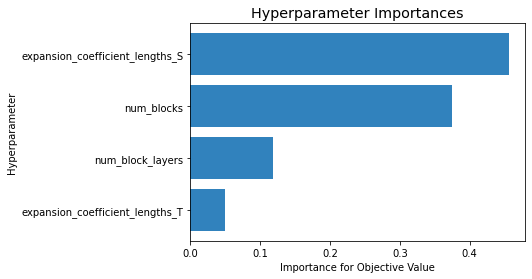

In [18]:
from optuna.visualization.matplotlib import plot_param_importances

_ = plot_param_importances(study)

We had also performed tuning for LSTM and obtained the following importances diagram.

![LSTM Hyperparameter Importances](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/lstm_param_impt.png)

For our hyperparameter tuning above, we only used the first CV split but as mentioned earlier, this is just to save time without losing the essence. In practice, we can also do this to narrow down the hyperparameter space first before running a proper nested walk-forward validation.

For your reference, we include an example code below for tuning with nested walk-forward validation:

```
def objective(trial):
    """
    Objective function to be used by Optuna to perform hyperparameter tuning
    for nested walk-forward validation
    """
    # computes the cross-validated weighted MAE for a model
    wmae_list = []

    # set number of cv splits
    cv = 3

    # define hyperparamter space
    params = {
        "num_blocks": trial.suggest_int("num_blocks", 1, 3, step=1),
        "num_block_layers": trial.suggest_int("num_block_layers", 1, 3, step=1),
        "expansion_coefficient_lengths_T": trial.suggest_int("expansion_coefficient_lengths_T", 2, 3, step=1),
        "expansion_coefficient_lengths_S": trial.suggest_int("expansion_coefficient_lengths_S", 2, 7, step=1),
    }

    for i in range(cv):
        expansion_coefficient_lengths = [params['expansion_coefficient_lengths_T'],params['expansion_coefficient_lengths_S']]
        num_blocks = [params['num_blocks'], params['num_blocks']]
        num_block_layers = [params['num_block_layers'], params['num_block_layers']] 
        model, trainer, train_dataloader, val_dataloader, test_dataloader = nbeats_modeler(training_df, validation_df,      
                                                                                        test_df, max_epochs=5, 
                                                                                        expansion_coefficient_lengths=expansion_coefficient_lengths, 
                                                                                        num_blocks=num_blocks, 
                                                                                        num_block_layers=num_block_layers)
        trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

        nbeats_val_df = return_nbeats_predictions(trainer, val_dataloader, validation_df)
        wmae = compute_wmae(validation_df, nbeats_val_df, 'sales', 'nbeats_pred')
        wmae_list.append(wmae)

    return np.mean(wmae_list)
```

## Conclusion

Great job on completing this last Milestone. With that, you have completed the liveProject and learnt to:
- Perform forecasting with LSTM and N-BEATS models
- Understand the concept of Cross Learning
- Enhance model performance with Ensembling technique
- Optimize model with Bayesian Optimization
- Evaluate model training with TensorBoard 

That's quite an accomplishment so give yourself a pat on the back.

In the next and final liveProject of this series, we shall learn to serve forecasts through API with model performance monitoring. Hope to see you there :)